In [8]:
import os
import json
import re
from langchain.chat_models import AzureChatOpenAI
from langchain_openai import AzureOpenAIEmbeddings
from langchain.vectorstores import Chroma
from dotenv import load_dotenv

In [9]:
load_dotenv()

# Access the environment variables
os.environ["AZURE_OPENAI_API_KEY"] = os.getenv("AZURE_OPENAI_API_KEY")
os.environ["AZURE_OPENAI_ENDPOINT"] = os.getenv("AZURE_OPENAI_ENDPOINT")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [27]:
llm = AzureChatOpenAI(
      temperature=0.5,
      model="gpt-4o",
      openai_api_version="2024-02-01",
      azure_deployment="gpt4o",
      max_tokens=700)

In [ ]:
from typing import TypedDict, List, Tuple

class ExpertState(TypedDict, total=False):
    goal: str
    prompt: str
    score: int
    feedback: str
    history: List[Tuple[str, str]]
    iteration: int  # Track iteration count

In [ ]:
# Worker 1: Generates or improves prompt
def worker_1(state: ExpertState) -> ExpertState:
    goal = state["goal"]
    feedback = state.get("feedback", "")
    history = state.get("history", [])
    iteration = state.get("iteration", 0)
    
    if feedback:
        prompt = llm.predict(
            f"The earlier prompt had issues: {feedback}. Please improve the prompt for: {goal}"
        )
    else:
        prompt = llm.predict(
            f"Create a high-quality prompt for: {goal}"
        )
    
    history.append(("Prompt by GPT-4o", prompt))
    
    return {
        "goal": goal,
        "prompt": prompt,
        "history": history,
        "iteration": iteration + 1
    }

# Worker 2: Evaluates the prompt
def worker_2(state: ExpertState) -> ExpertState:
    prompt = state["prompt"]
    history = state.get("history", [])
    
    evaluation = llm.predict(
        f"""Evaluate the following prompt for clarity, specificity, and effectiveness (1-10). 
        If it has flaws, mention them briefly.\nPrompt: {prompt}"""
    )

    # Parse score and feedback (you can use better NLP parsing here)
    try:
        score = int([s for s in evaluation.split() if s.isdigit()][0])
    except:
        score = 5  # fallback

    # print(score)
    
    feedback = evaluation if score < 8 else ""
    
    history.append(("Feedback by GPT-4o", evaluation))
    
    return {
        "score": score,
        "feedback": feedback,
        "prompt": prompt,
        "goal": state["goal"],
        "history": history,
        "iteration": state["iteration"]
    }

In [42]:
def supervisor(state: ExpertState) -> str:
    if state["score"] >= 8 or state["iteration"] >= 5:
        return "end"
    else:
        return "improve"

In [43]:
from langgraph.graph import StateGraph, END

builder = StateGraph(ExpertState)

builder.add_node("worker_1", worker_1)
builder.add_node("worker_2", worker_2)

builder.set_entry_point("worker_1")
builder.add_edge("worker_1", "worker_2")

builder.add_conditional_edges("worker_2", supervisor, {
    "improve": "worker_1",
    "end": END
})

graph = builder.compile()

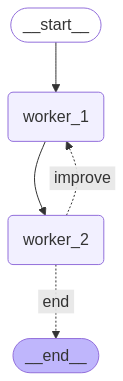

In [44]:
graph.validate()

In [ ]:
initial_state = {
    "goal": "Write a prompt to extract entities from legal contracts using a language model.",
    "history": [],
    "iteration": 0  # Start from iteration 0
}

final_state = graph.invoke(initial_state)

print("\n Final Prompt:\n", final_state["prompt"])
print("\n Feedback History:")
for h in final_state["history"]:
    print(f"{h[0]}: {h[1]}")

5
5
5
5
5

✅ Final Prompt:
 Sure, I can help improve the prompt based on your feedback. Here's a revised version:

---

**Prompt: Extracting Entities from Legal Contracts Using a Language Model**

**Task Description:**

Your task is to extract specific entities from legal contracts using a language model. The entities to be extracted are:

1. **Parties Involved**: The names of the entities entering into the contract.
2. **Effective Date**: The date when the contract comes into effect.
3. **Termination Date**: The date when the contract ends or the conditions under which it can be terminated.
4. **Governing Law**: The legal jurisdiction under which the contract is governed. For example, if there are multiple governing laws, use 'Governing Law': ["Jurisdiction1", "Jurisdiction2"].
5. **Obligations and Responsibilities**: The key obligations and responsibilities of each party. If there are multiple obligations for a party, list them as an array.
6. **Initial Term**: The initial duration o

In [2]:
# from fastapi import FastAPI, HTTPException
# import uvicorn

In [1]:
# app = FastAPI()

# @app.post("/generate_prompt/")
# async def generate_prompt(state: ExpertState):
#     try:
#         final_state = graph.invoke(state.dict())
#         return {
#             "final_prompt": final_state.prompt,
#             "history": final_state.history
#         }
#     except Exception as e:
#         raise HTTPException(status_code=500, detail=str(e))

# # Run the server
# if __name__ == "__main__":
#     uvicorn.run(app, host="0.0.0.0", port=8000)